In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
#import nn_lut_expo as nl
from keras import backend as K
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
from timeit import default_timer as timer
from tensorflow.keras.models import load_model

In [3]:
data = pd.read_csv('Binary_dataset.csv')

label_encoder = LabelEncoder()
data['CAN_ID'] = label_encoder.fit_transform(data['CAN_ID'])
data['DATA'] = label_encoder.fit_transform(data['DATA'])
X = data[['Timestamp', 'CAN_ID', 'DLC', 'DATA']].values
y = data['Class'].values

# Normalize the features using StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

X = X.reshape(X.shape[0], 1, X.shape[1])

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [33]:

# Define the path to the saved Keras model file
model_file_path = 'Multiclass_model.h5'

# Load the saved Keras model
model = load_model(model_file_path)
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 64)                13440     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 3)                 27        
                                                                 
Total params: 13,987
Trainable params: 13,987
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.trainable_variables[5]

<tf.Variable 'dense_3/kernel:0' shape=(8, 3) dtype=float32, numpy=
array([[-6.3860564 , -1.524948  , -4.110489  ],
       [-3.7269406 , -6.854186  , -1.0608506 ],
       [-1.5770223 , -3.265249  , -0.6294347 ],
       [ 0.17554714, -9.97317   , -0.5776171 ],
       [-0.3480661 , -3.4693432 , -0.3560852 ],
       [-4.8430076 , -1.647973  , -4.5832195 ],
       [ 1.9935324 , -1.6728908 , -3.627279  ],
       [-1.9666193 , -4.186611  , -7.9051576 ]], dtype=float32)>

In [19]:
np.savez('single_test_data.npz', array1=x_test[0], array2=y_test[0])
# Load the arrays from the .npz file
loaded_data = np.load('single_test_data.npz')

# Access individual arrays by their names
loaded_x_test = loaded_data['array1']
loaded_y_test = loaded_data['array2']

# Now you can use the loaded arrays as needed
#print(loaded_x_test)
#print(loaded_y_test)


# we'll measure the accuracy of NN_LUT results on trained value over softmax

In [20]:
n = np.array([1.4361087, 4.2334495, 3.85742  , 4.264582 , 3.8623135, 5.329231 ,
        4.59598  , 4.5642357, 4.0106244, 3.768467 , 4.0424323, 4.7826633,
        3.8420782, 3.8410342, 3.978158 , 3.8407047]) ## dtype=float32

b = np.array([3.6729612, 2.4222262, 2.6400049, 2.3553596, 2.6376493, 1.6942859,
       2.2128122, 2.1753068, 2.5537484, 2.65736, 2.4797037, 1.9942976,
       2.6000817, 2.602181 , 2.5191853, 2.6025882]) ##dtype=float32

m = np.array([ 0.16392513, 0.40462586, 0.50942373, -0.27365214, 0.52273303, 0.06400099, 0.2643626, -0.18569617, 0.49074554,0.5214768,-0.30852234,
       -0.06019293, -0.46837196, -0.50730234, -0.34195417, -0.5151364]) ## dtype=float32


break_points  = -(b/n)
d = np.sort(break_points, axis = 0)

In [21]:
def linear(n1,b1,m1):
    s = []
    t = []
    s.clear()
    t.clear()
    op = 16
    for i in range(op):
        a1_tmp = 0
        a2_tmp = 0
        b1_tmp = 0
        b2_tmp = 0
        a_ = 0
        b_ = 0
        s_tmp = 0
        t_tmp = 0

### first summation for both of the terms in equation 7
        for j in range(i+1):
             if n1[j]>0:
                a1_tmp+= n1[j]
                #b1_tmp+= (n1[j] * (b1[j]/n1[j]))
                b1_tmp+= b1[j]         
                continue
                
### second summation for both of the terms in equation 7                  
        for q in range(i+1, op):
            if n1[q]<0:
                a2_tmp+= n1[q]
                #b2_tmp+= (n1[q] * (b1[q]/n1[q]))
                b2_tmp+= b1[q]
                continue
        a_+= (a1_tmp + a2_tmp)  ## m*(summation of positive and negative but for weights)
        b_+= (b1_tmp + b2_tmp)   ## m*(summation of positive and negative but for bias)
    
###finally calculate the value for LUT_parameters s,t   
        s_tmp = (m1[i]*(a_)) 
        s.append(s_tmp)
        t_tmp = (m1[i] *(b_))    
        t.append(t_tmp)   
    return s,t 

In [22]:
s, t = linear(n,b,m)
s = np.array(s, dtype = 'float16')
t = np.array(t, dtype = 'float16')
d = np.array(d, dtype = 'float16')
# print(loaded_s)
# print(loaded_t)
# print(loaded_d)

np.savez('std.npz', array1=s, array2=t, array3=d)
# Load the arrays from the .npz file
loaded_data = np.load('std.npz')

# Access individual arrays by their names
loaded_s = loaded_data['array1']
loaded_t = loaded_data['array2']
loaded_d = loaded_data['array3']

# Now you can use the loaded arrays as needed
# print(loaded_s)
# print(loaded_t)
# print(loaded_d)


In [23]:
def ex_LUT(x): 
    t_n = 16
    if x< d[1]:
        #print('d1', d[1])
        return s[0]*x + t[0] 

        
    elif x>=d[t_n-1]:  #value of X>= d14
        #print('d_end',d[t_n-1])
        return s[t_n-1]*x + t[t_n-1]
                
    else: 
        
        for i in range(1,t_n-1): # value of X>= d1 and X< d15
            if d[i]<=x<d[i+1]:   
               # print('di',d[i])
                return s[i] * x + t[i]
                break

In [58]:

# with a Sequential model

get_2th_layer_output = K.function([model.layers[0].input],
                                  [model.layers[1].output])

layer_output1 = np.array(get_2th_layer_output(x_test))
layer_output1 = layer_output1.reshape(359510, 8)
#print(layer_output1.shape)

# ''' weights and biases from 2nd last layer'''

w_le_model = np.array(model.trainable_variables[5])
b_le_model = np.array(model.trainable_variables[6])

# reshape the array for concatenation of Wo,mn and bo, so Wo,(mn+1)
w_le_model = np.transpose(w_le_model)
b_le_model = b_le_model.reshape(3,1)## shape is now [3,1]
#print(w_le_model.shape, b_le_model.shape)
v = np.concatenate((w_le_model,b_le_model), axis =1)


(3, 9)

In [84]:
v.shape  ##shape is now [3,9]  weight and bias in one array
layer_output1.shape

(359510, 8)

In [86]:
gru_model_input1 = []
# #extra padding for X(mn+1),1
extra = np.array((1))
extra.shape = (1,1)

In [87]:

for i in layer_output1:
    i.shape = (8,1)
    u = np.concatenate((i,extra), axis =0) ##shape is (9,1)
    #print(u.shape)
    j = np.dot(v,u) ## shape is (3,1)
    #print(j.shape)
    gru_model_input1.append(j)
    
med1 = np.array(gru_model_input1, dtype='float32')   
med1.shape

(359510, 3, 1)

In [119]:
med1 = med1.reshape(359510, 3)
med1.shape

(359510, 3)

In [120]:
np.savez('med1[0].npz', array1=med1[0])
# Load the arrays from the .npz file
loaded_data = np.load('med1[0].npz')

# Access individual arrays by their names
loaded_med1 = loaded_data['array1']
print(loaded_med1)

[  26.21142  -251.01735   -86.057655]


## LUT Prediction time

In [137]:
fm = []

start0 = timer()
for i in med1[0]:
#     print(i.dtype)
    fix_3 = ex_LUT(i)      
    fm.append(np.abs(fix_3))
end0 = timer()
prediction_LUT_time = (end0-start0) *1000
fm

[887.9498, 58.505917, 19.662258]

In [138]:
print("LUT Model Prediction Time for a Single Data Point:", "{:.2f} ms".format(prediction_LUT_time))

LUT Model Prediction Time for a Single Data Point: 0.13 ms


In [107]:
final_t = []

In [108]:
start0 = timer()
for i in med1:
    fint = []
    #print(i)
    for j in i:
        #print(j)
        fix1 = ex_LUT(j)
        #print(fix1)
        fint.append(np.abs(fix1))
    final_t.append(fint)
end0 = timer()
print(end0-start0)
LUT_result_t = np.array(final_t) 


1.6960013000007166


In [109]:
LUT_result_t.shape

(359510, 3)

In [113]:
for i in y_test:
    print(i)

0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
2
1
0
0
0
0
0
0
0
1
1
0
1
0
1
0
0
0
0
2
0
0
0
2
0
0
2
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
2
0
0
2
0
0
0
0
0
0
1
1
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
2
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
1
2
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
2
0
0
1
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
1
2
0
0
2
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
2
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
2
0
2
2
2
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
2
0
1
0
0
0
2
0
2
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
1
0
2
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
2
0
0
2
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
2
2
0
0
0
0
0
1
0
2
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
1
2
0
1
0
0
0
1
0
0
0
0
0
1
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
2
0
0
1
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
1
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
2
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
2
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
2
0
0
0
1
0
0
0
0
1
0
0
1
0
2
2
0
0
1
0
0
0
1
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
1
0
1
2
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
2
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
2
0
0
2
0
0
1
0
0
0
0
1
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
2
0
1
0
0
1
0
0
0
1
0
2
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
2
1
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
1
1
0
2
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
1
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
1
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
2
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
2
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
2
0
0
0
0
0
0
1
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
2
1
0
0
0
0
0
0
0
2
0
0
0
0
2
0
0
0
2
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
1
2
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
2
1
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
2
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
2
0
0
2
0
0
0
0
1
0
0
0
1
0
0
0
0
1
1
0
0
2
0
0
1
0
0
1
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
2
0
2
0
0
0
0
0
0
0
2
0
0
0
1
0
2
0
0
0
0
0
0
0
0
1
0
0
2
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0


In [110]:
predicted_t = [np.argmax(i) for i in LUT_result_t]
predicted_t

[0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 2,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 2,
 0,
 1,
 0,
 1,
 0,
 2,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 1,
 0,
 0,
 0,
 0,


Text(33.22222222222222, 0.5, 'ground truth')

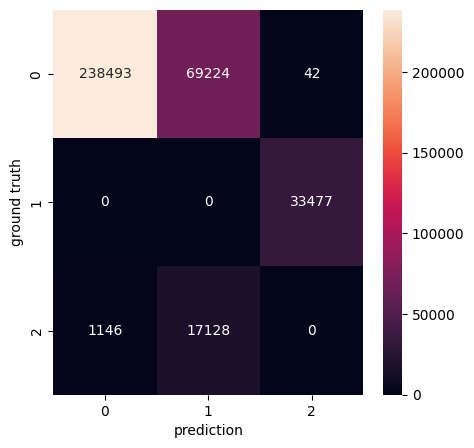

In [111]:
cmat = tf.math.confusion_matrix(labels=y_test, predictions=predicted_t)

plt.figure(figsize=(5,5))
sns.heatmap(cmat, annot=True, fmt='d')
plt.xlabel('prediction')
plt.ylabel('ground truth')

In [112]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, predicted_t)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, predicted_t, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, predicted_t, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, predicted_t, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, predicted_t, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, predicted_t, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, predicted_t, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, predicted_t, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, predicted_t, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, predicted_t, average='weighted')))


Accuracy: 0.66

Micro Precision: 0.66
Micro Recall: 0.66
Micro F1-score: 0.66

Macro Precision: 0.33
Macro Recall: 0.26
Macro F1-score: 0.29

Weighted Precision: 0.85
Weighted Recall: 0.66
Weighted F1-score: 0.75


In [114]:
def softmax(x):
    return(np.exp(x)/np.exp(x).sum())

soft_ = []

## Softmax Prediction time

In [155]:
start1 = timer()
for i in med1[0]:
#     print(i)
    fix1 = softmax(j)
        #print(fix1)
    soft_.append(fix1)
    
end1 = timer()        
sfm = np.array(soft_) 

soft_prediction_time = (end1 - start1)*1000

C:\Users\User\AppData\Local\Temp\ipykernel_16444\1524048133.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sfm = np.array(soft_)


In [156]:
print("Softmax Model Prediction Time for a Single Data Point:", "{:.2f} ms".format(soft_prediction_time))

Softmax Model Prediction Time for a Single Data Point: 0.14 ms


In [117]:
soft_ = []
med1.shape

(359510, 3)

In [118]:

start1 = timer()
for i in med1:
    sof_ = []
    #print(i.dtype)
    for j in i:
        #print(j)
        fix1 = softmax(j)
        #print(fix1)
        sof_.append(fix1)
    soft_.append(sof_)
end1 = timer()        
sfm = np.array(soft_) 

print(end1 - start1)
sfm[0]

C:\Users\User\AppData\Local\Temp\ipykernel_16444\4214658555.py:2: RuntimeWarning: invalid value encountered in float_scalars
  return(np.exp(x)/np.exp(x).sum())


4.021536799999922


array([ 1., nan,  1.], dtype=float32)

## time improvement of using LUT on TFLite fp16 model over using softmax for single data point

In [73]:
improved_time = prediction_le_fp16_time + prediction_LUT_time - soft_prediction_time
print("Improved Prediction Time for a Single Data Point:", "{:.2f} ms".format(improved_time))

Improved Prediction Time for a Single Data Point: 0.35 ms


In [74]:
sfm_t = [np.argmax(i) for i in sfm]
sfm_t

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [79]:
cmat = tf.math.confusion_matrix(labels=y_test, predictions=sfm)

plt.figure(figsize=(5,5))
sns.heatmap(cmat, annot=True, fmt='d')
plt.xlabel('prediction')
plt.ylabel('ground truth')

InvalidArgumentError: {{function_node __wrapped__Pack_N_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Shapes of all inputs must match: values[0].shape = [10000] != values[1].shape = [10000,10] [Op:Pack] name: stack

In [ ]:
for i in med:
    print(i)

In [ ]:
# sfm_test = [np.argmax(i) for i in predicted_sfm_test]
# cmat = tf.math.confusion_matrix(labels=y_train[0], predictions=predicted)

# plt.figure(figsize=(5,5))
# sns.heatmap(cmat, annot=True, fmt='d')
# plt.xlabel('prediction')
# plt.ylabel('ground truth')

# softmax result

In [68]:
predicted_sfm = le_model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0444 - accuracy: 0.9907


In [108]:
x_test[0].shape

(28, 28)

In [109]:
x_test[0].reshape([1,28,28,1])

le_model.predict(x_test[0])

InvalidArgumentError: Graph execution error:

Detected at node 'sequential/layer1/Relu' defined at (most recent call last):
    File "c:\users\user\appdata\local\programs\python\python38\lib\runpy.py", line 192, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\users\user\appdata\local\programs\python\python38\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\users\user\appdata\local\programs\python\python38\lib\asyncio\base_events.py", line 563, in run_forever
      self._run_once()
    File "c:\users\user\appdata\local\programs\python\python38\lib\asyncio\base_events.py", line 1844, in _run_once
      handle._run()
    File "c:\users\user\appdata\local\programs\python\python38\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\User\AppData\Local\Temp\ipykernel_14928\2842372081.py", line 1, in <module>
      le_model.predict(x_test[0])
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 2382, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 2169, in predict_function
      return step_function(self, iterator)
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 2155, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 2143, in run_step
      outputs = model.predict_step(data)
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
      return self(x, training=False)
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\keras\engine\sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\keras\layers\convolutional\base_conv.py", line 321, in call
      return self.activation(outputs)
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\users\user\appdata\local\programs\python\python38\lib\site-packages\keras\backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'sequential/layer1/Relu'
convolution input must be 4-dimensional: [28,28]
	 [[{{node sequential/layer1/Relu}}]] [Op:__inference_predict_function_75599]

In [ ]:
sfm = [np.argmax(i) for i in predicted_sfm]
cmat = tf.math.confusion_matrix(labels=y_test, predictions=sfm)

plt.figure(figsize=(5,5))
sns.heatmap(cmat, annot=True, fmt='d')
plt.xlabel('prediction')
plt.ylabel('ground truth')